## Imports

### Basic imports

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

### SciKit Learn Imports

#### Models imports

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

#### Other sklearn imports

In [17]:
import sklearn.model_selection as ms
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

## Getting White Wine Data

In [18]:
fl = "winequality-white.csv"
table = pd.read_csv(fl, delimiter = ";", header='infer')
table.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Print Histogram

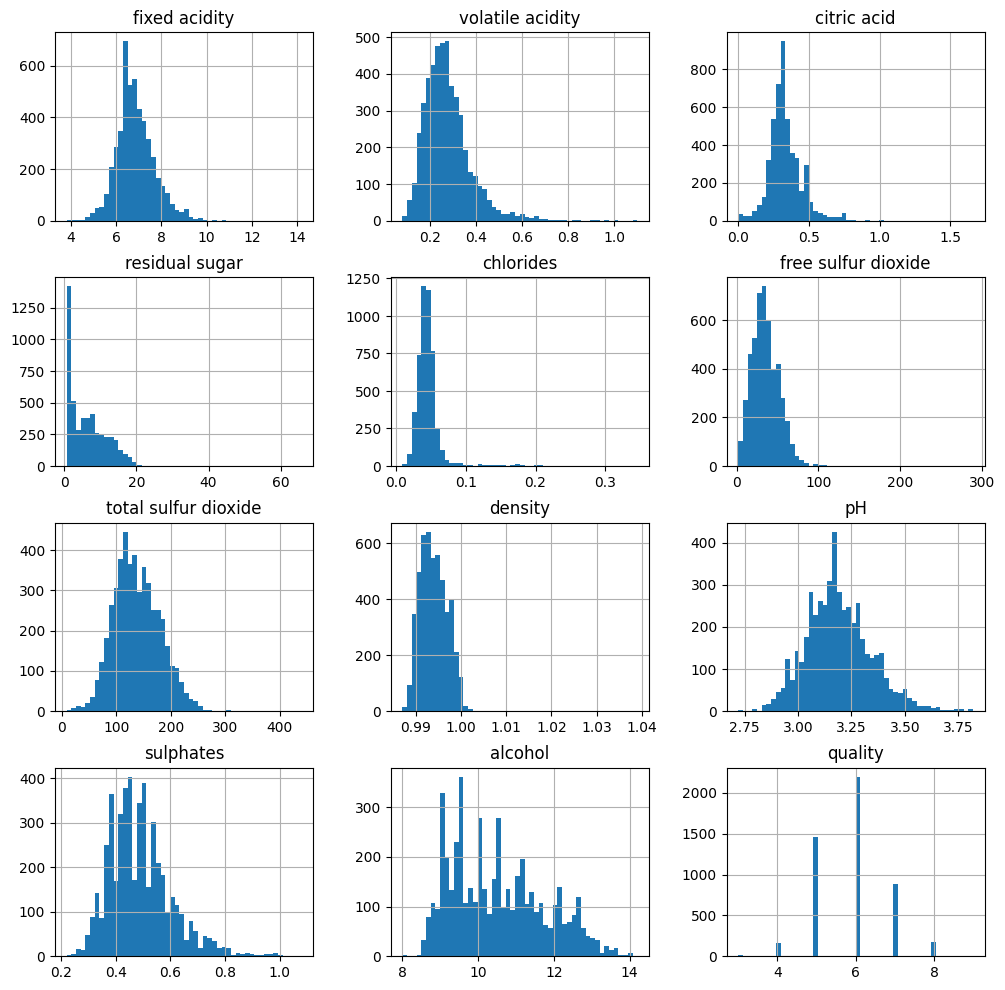

In [19]:
table.hist(figsize=(12,12),bins = 50)
plt.savefig("figures/historgram.png")

## Find nans

In [20]:
nans = table.loc[:, table.columns[table.isna().any()].tolist()]
nans.head()

""
0
1
2
3
4


There are no columns, so there is not any nan values in the data, correlating correctly with the dataset description

## Finding outliers
 We are predicting quality, as suggested about the data
 Scatterplots will visually show outliers

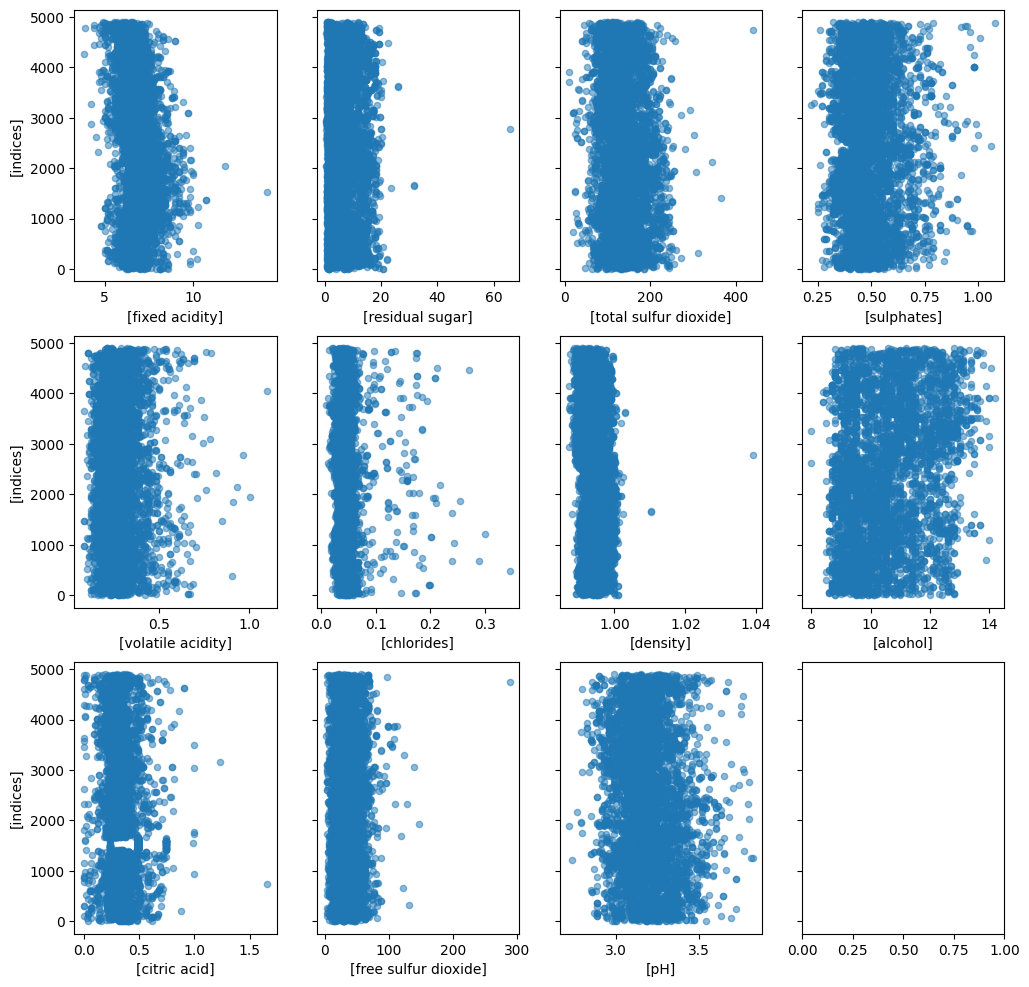

In [21]:
# Subplot scatter plots
fig, axes = plt.subplots(3,4, sharey=True)
k = 0
j = 0

# Indices for the plot
indices = []
for i in range(len(table.values)):
    indices.append(i)

# Temporarily add indices to table
table["indices"] = np.asarray(indices)

# Look at all of our data except for the logarithmic features
for col in table.columns.values[:-2]:
    # Go to next row
    if k == 3:
        k = 0
        j += 1
    
    # Plot a scatterplot of our 
    table.plot(y = ["indices"], x=[col], use_index=True, kind="scatter", ax=axes[k][j],figsize = (12,12),alpha = 0.5)
    k+= 1

table.drop(columns=["indices"], inplace=True)
plt.savefig("figures/scatter_hist.png")

Now, looking at our scatterplots, we remove the data lines where we determine there to be outliers.

## Removing outliers

In [22]:
# Removes a row of a dataframe given a certain threshold
def drop_row(col, threshold):
    index = table.index[table[col] > threshold]
    table.drop(index, axis= 0, inplace = True)
    return

In [23]:
# Residual sugar
drop_row("residual sugar", 60)

# Density
drop_row("density", 1.01)

# Free sulfur dioxide
drop_row("free sulfur dioxide", 200)

# Citric acid
drop_row("citric acid", 1.5)

### Fixed Acidity
Even though fixed acidity looks to have an outlier, it was kept as its singular outlier datapoint is not far off from the second farthest datapoint, which also is not far from the cluster of all the other data for the fixed acidity variable. As a result, this seems to be natural variance, and as such, it was kept.

## Testing for logarithmic data

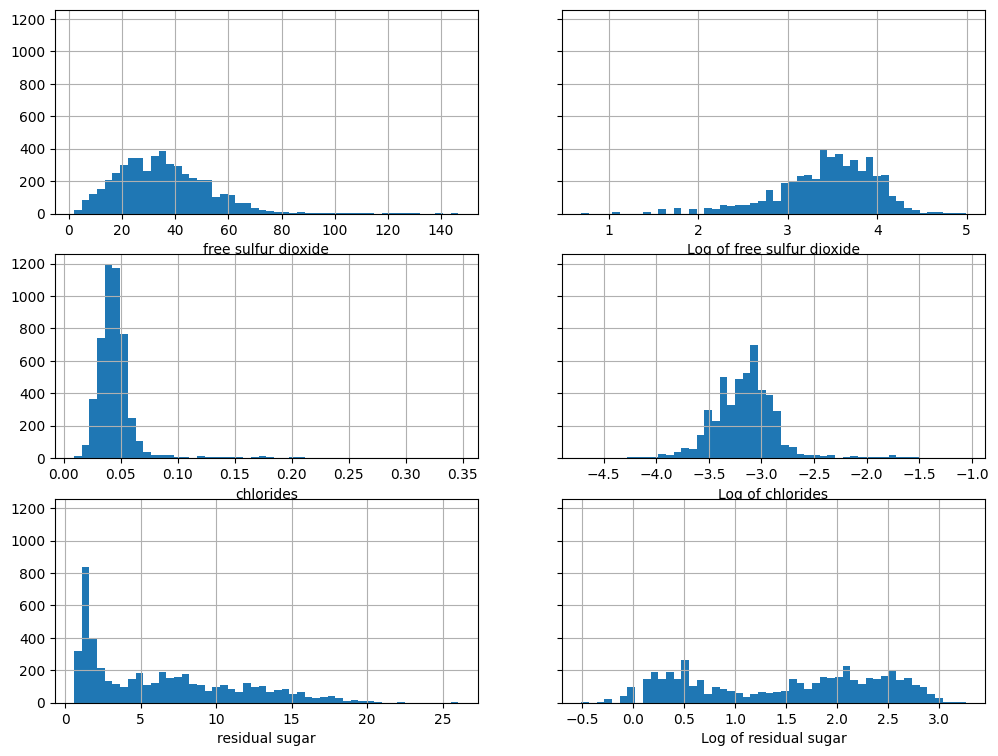

In [24]:
labels = ["free sulfur dioxide", "chlorides", "residual sugar"]
new_column_labels = ["log_fsd", "log_chloride", "log_res_sugar"]
for i in range(len(labels)):
    table[new_column_labels[i]] = table[labels[i]].apply(np.log)

fig, axs = plt.subplots(3, 2, figsize=(12, 9), sharey=True)
for i in range(len(labels)):
    table[labels[i]].hist(ax=axs[i][0], bins=50)
    table[new_column_labels[i]].hist(ax=axs[i][1], bins=50)


    axs[i][0].set_xlabel(labels[i])
    axs[i][1].set_xlabel(f"Log of {labels[i]}")
plt.savefig("figures/hist_comparison.png")

We look at the correlations with quality and choose the top 6, this will decrease chances of overfitting by having insignificant features.

## Algorithms

### Function for cross validation

In [25]:
# Runs cross validation on given model and features
def get_scoring_stats(X, y, model, scoring_metric):
    # Standardize features
    pipeline = make_pipeline(StandardScaler(), model) 

    # Cross validate with our standardized model
    cv = ms.cross_validate(pipeline, X=X, y=y, cv = 5, scoring = scoring_metric)

    # Return the mean, standard deviation, and total time
    mean_score = np.mean(cv["test_score"])
    std_dev = np.std(cv["test_score"])
    tot_time = np.sum(cv["fit_time"])

    results = {"score": mean_score, "time": tot_time, "std dev": std_dev}
    return results


### Function for having our algorithms

In [26]:
# Get an array of models with random seed input
def random_models(random_state_seed):
    models = [DecisionTreeClassifier(random_state=random_state_seed),\
        RandomForestClassifier(random_state=random_state_seed),\
        KNeighborsClassifier(),\
        GradientBoostingClassifier(random_state = random_state_seed),\
        LogisticRegression(solver = "liblinear", random_state = random_state_seed)]
    return models

## Feature Selection

In [27]:
table_corr = table.corr()
corr_quality = table_corr["quality"].apply(np.abs).sort_values(ascending=False)
print(corr_quality.to_latex())

\begin{tabular}{lr}
\toprule
{} &   quality \\
\midrule
quality              &  1.000000 \\
alcohol              &  0.436352 \\
density              &  0.317777 \\
log\_chloride         &  0.273210 \\
chlorides            &  0.210216 \\
volatile acidity     &  0.196209 \\
total sulfur dioxide &  0.171180 \\
fixed acidity        &  0.114565 \\
log\_fsd              &  0.102166 \\
residual sugar       &  0.100674 \\
pH                   &  0.100657 \\
log\_res\_sugar        &  0.065306 \\
sulphates            &  0.054639 \\
free sulfur dioxide  &  0.018558 \\
citric acid          &  0.010157 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_466501/344192464.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(corr_quality.to_latex())


### Running the algorithms 30 times each

In [28]:
# We are aiming to predict quality with the features chosen from the correlations
features = ["alcohol", "density", "log_chloride", "volatile acidity", "total sulfur dioxide", "fixed acidity", "log_fsd"]
X = table[features]
y = table.quality

# Translation for indices and model names
translation = {0: "decision tree", 1: "random forest", 2: "k nearest neighbors", 3: "gradient boosting", 4: "logistic regression"}

# Dictionaries to store the results
Accuracies = {}
Std_dev = {}
Time = {}

# Run 30 times
for i in range(30):
        # Storing run data
        mean_accuracies_for_models = {}
        std_dev_for_models = {}
        tot_time_for_models = {}

        # Generating models with random seed i
        models = random_models(i)

        # Cross validate for each model
        for j in range(5):
                results = get_scoring_stats(X, y, models[j], "accuracy")
                mean_accuracies_for_models[translation[j]] = results["score"]
                tot_time_for_models[translation[j]] = results["time"]
                std_dev_for_models[translation[j]] = results["std dev"]

        # Store run data
        Accuracies[i] = mean_accuracies_for_models
        Std_dev[i] = std_dev_for_models
        Time[i] = tot_time_for_models


## Results

### Turn our results into tables

In [29]:
accuracy_df = pd.DataFrame.from_dict(Accuracies)
time_df = pd.DataFrame.from_dict(Time)
std_dev_df = pd.DataFrame.from_dict(Std_dev)

### Pickling the data for easy data retrieval if lost with the notebook

In [30]:
# Pickle the data
def pickle_df(df, fname):
    with open(fname, "wb+") as f:
        pickle.dump(df,f)
    return

# Unpickle the data
def get_df_from_pickle(fname):
    with open(fname, "rb") as f:
        df = pickle.load(f)
    return df

In [31]:
# Pickle the data
pickle_df(time_df, "time.pkl")
pickle_df(accuracy_df, "accuracy.pkl")
pickle_df(std_dev_df, "std_dev.pkl")

In [32]:
# Retrieving the data
# Uncomment if need to retrieve data without rerunning data.
# ONLY unpickle things you trust

# accuracy_df = get_df_from_pickle("accuracy.pkl")
# std_dev_df = get_df_from_pickle("std_dev.pkl")
# time_df = get_df_from_pickle("time.pkl")

### Plotting data

#### Heatmap for accuracy

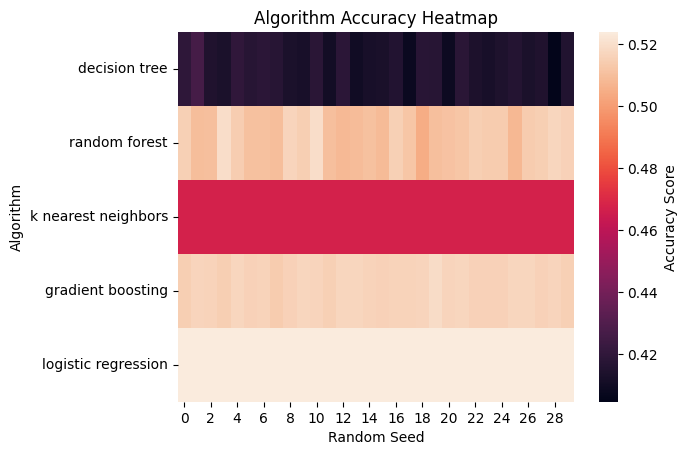

In [33]:
ax = sns.heatmap(accuracy_df,cbar_kws={"label":"Accuracy Score"})
plt.title("Algorithm Accuracy Heatmap")
plt.xlabel("Random Seed")
plt.ylabel("Algorithm")

plt.savefig("figures/acc_hm")

#### Heatmap for standard deviation

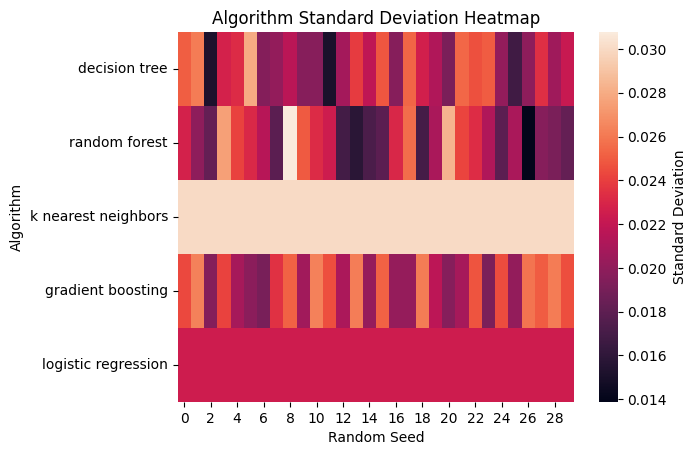

In [34]:
ax = sns.heatmap(std_dev_df,cbar_kws={"label":"Standard Deviation"})
plt.title("Algorithm Standard Deviation Heatmap")
plt.xlabel("Random Seed")
plt.ylabel("Algorithm")

plt.savefig("figures/std_hm")

#### Heatmap for Time

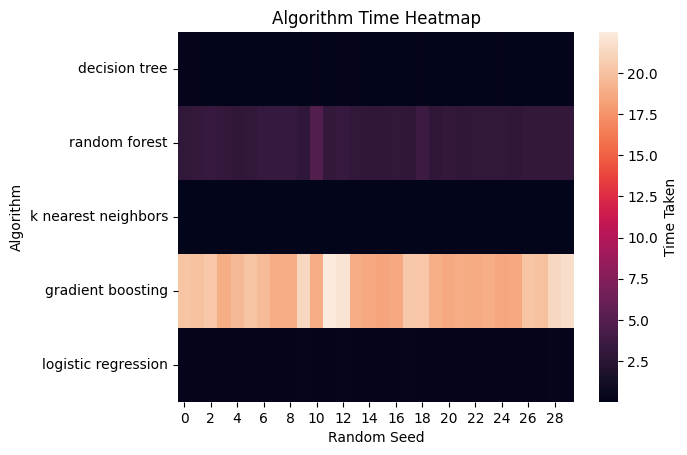

In [35]:
ax = sns.heatmap(time_df,cbar_kws={"label":"Time Taken"})
plt.title("Algorithm Time Heatmap")
plt.xlabel("Random Seed")
plt.ylabel("Algorithm")

plt.savefig("figures/time_hm")

### Average data in final table

In [36]:
final_df = pd.DataFrame()
for model in translation.values():
    # Going over rows, since algorithms are rows

    final_df[model] = [np.mean(accuracy_df.T[model].mean()), np.mean(std_dev_df.T[model].mean()), np.mean(time_df.T[model].mean())]
final_df.index = ["Average Accuracy", "Average Standard Deviation", "Average Time"]
print(final_df)
print(final_df.style.to_latex())
final_df

                            decision tree  random forest  k nearest neighbors  \
Average Accuracy                 0.414718       0.512424             0.467210   
Average Standard Deviation       0.021763       0.021252             0.029994   
Average Time                     0.115949       3.107102             0.035419   

                            gradient boosting  logistic regression  
Average Accuracy                     0.516192             0.523814  
Average Standard Deviation           0.022851             0.022440  
Average Time                        19.702670             0.181427  
\begin{tabular}{lrrrrr}
 & decision tree & random forest & k nearest neighbors & gradient boosting & logistic regression \\
Average Accuracy & 0.414718 & 0.512424 & 0.467210 & 0.516192 & 0.523814 \\
Average Standard Deviation & 0.021763 & 0.021252 & 0.029994 & 0.022851 & 0.022440 \\
Average Time & 0.115949 & 3.107102 & 0.035419 & 19.702670 & 0.181427 \\
\end{tabular}



,decision tree,random forest,k nearest neighbors,gradient boosting,logistic regression
Average Accuracy,0.414718,0.512424,0.467210,0.516192,0.523814
Average Standard Deviation,0.021763,0.021252,0.029994,0.022851,0.022440
Average Time,0.115949,3.107102,0.035419,19.702670,0.181427


In [37]:
from scipy import stats
stats.ttest_rel(accuracy_df.T["decision tree"], accuracy_df.T["random forest"])[1]

row = {}
for model in translation.values():
    col = {}
    for model2 in translation.values():
        if model == model2:
            col[model2] = 0
        else :
            col[model2] = stats.ttest_rel(accuracy_df.T[model], accuracy_df.T[model2])[1]
    row[model] = col
t_test_df = pd.DataFrame.from_dict(row)
print(t_test_df.to_latex())
# t_test_df

\begin{tabular}{lrrrrr}
\toprule
{} &  decision tree &  random forest &  k nearest neighbors &  gradient boosting &  logistic regression \\
\midrule
decision tree       &   0.000000e+00 &   6.269056e-37 &         1.324002e-33 &       9.522989e-42 &         8.649380e-43 \\
random forest       &   6.269056e-37 &   0.000000e+00 &         7.542044e-34 &       1.207819e-05 &         5.367420e-17 \\
k nearest neighbors &   1.324002e-33 &   7.542044e-34 &         0.000000e+00 &       2.270862e-50 &         0.000000e+00 \\
gradient boosting   &   9.522989e-42 &   1.207819e-05 &         2.270862e-50 &       0.000000e+00 &         4.815800e-27 \\
logistic regression &   8.649380e-43 &   5.367420e-17 &         0.000000e+00 &       4.815800e-27 &         0.000000e+00 \\
\bottomrule
\end{tabular}



/home/aolguin1/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/tmp/ipykernel_466501/1738896036.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(t_test_df.to_latex())
